In [33]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Nstatic = 12
Nmobile = 3
Ttotal = 1000 #number of time steps (hours)
Nrefs = 2 #the first few static sensors are reference
Nvisitsperday = 5 #expected number of times each mobile sensor visits a static sensor.
#in reality the boda drivers have their own 'patches' which mean that they are more likely
#to visit sensors in their own patch,
#withinsubgraphratio = 0.9 #proportion of visits to sensors in own subgraph
#referencesensorratio = 0.1 #proportion of visits that are to the reference sensor

refsensor = np.zeros(Nstatic+Nmobile)
refsensor[0:Nrefs]=1

# Synthetic Data

We build our synthetic data by temporarily building a simulation of the locations of the static sensors and the centres of the mobile (boda-boda) motorbike taxi activities. The boda-bodas are organised to have particular waiting areas, known as stages, around the city. Typically a boda-boda will have one stage they are allowed to wait at. They are also therefore more likely to visit sensors in their part of the city.

We simulate this by selecting randomly locations for these stages and then assign a probability of visiting proportional to  the inverse distance.

With only two or three reference sensors arranged across Kampala we pay the boda-boda drivers to visit them once a week to recalibrate the mobile sensors. Future papers will explore the optimum sequence of visits.

In [34]:
def getrealpolution(t,loc):
    return (loc[0]*30+10*np.cos(loc[1]*4))*np.sin(t/2.3)+np.cos(t/10)*30+loc[0]*5+loc[1]*3+50

In [35]:
def getstaticsensortranform(t,pol,sensor):
    if sensor<Nrefs: return pol
    #noisescale = 1*(1+np.cos(t*0.002*(1+sensor/3))+np.sin(t*0.001*(1+sensor/10)))
    noisescale = 2#
    return pol*(1+0.2*np.sin(1+sensor)+0.2*np.cos(t*0.01*(1+np.cos(sensor))+sensor)) + np.random.randn()*noisescale

def getmobilesensortranform(t,pol,sensor):
    #noisescale = 1*(1+np.cos(t*0.002*(1+sensor/3))+np.sin(t*0.001*(1+sensor/10)))
    noisescale = 5
    return pol*(1+0.2*np.sin(4+sensor)+0.3*np.cos(t*0.01*(1+np.cos(4+sensor))+3+sensor)) + np.random.randn()*noisescale

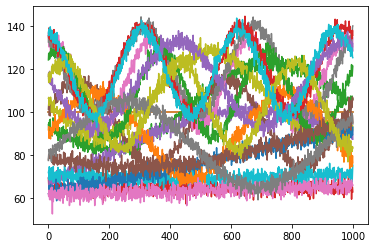

In [36]:
for s in range(0,20,1):
    plt.plot([getstaticsensortranform(t,100,s) for t in np.arange(0,Ttotal,1)])

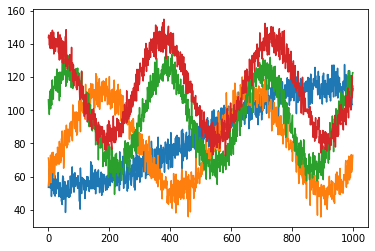

In [37]:
for s in range(0,4,1):
    plt.plot([getmobilesensortranform(t,100,s) for t in np.arange(0,Ttotal,1)])

In [38]:
statics = np.random.rand(Nstatic,2)
mobilecentres = np.random.rand(Nmobile,2)

In [39]:
invdistances = 1/np.sqrt(np.sum((mobilecentres-statics[:,None,:])**2,2))
probs = invdistances/np.sum(invdistances,0)

Ignoring night/day, we simply note that each hour has a probability of approximately Nvisitsperday/24. We multiply this by the probabilities assigned to each static sensor (for being visited by each mobile sensor).

In [40]:
probs = (Nvisitsperday/24)*probs

In [41]:
X = np.zeros([0,3])
Y = np.zeros([0,2])
for t in range(Ttotal):
    stats,mobs = np.where(np.random.random_sample(probs.shape)<probs)
    tempt = t
    for stat,mob in zip(stats,mobs):
        pol = 100#getrealpolution(t,statics[stat])
        Nsamps = 10
        polstat = [getstaticsensortranform(t,pol,stat) for i in range(Nsamps)]
        polmobile = [getmobilesensortranform(t,pol,mob) for i in range(Nsamps)]

        newX = np.c_[np.linspace(tempt,tempt+0.33,10)[:,None],np.full(10,stat),np.full(10,mob+Nstatic)]
        newY = np.c_[polstat,polmobile]
        X = np.r_[X,newX]
        Y = np.r_[Y,newY]
        tempt+=0.33

(-0.015193518785451082,
 0.9996621028648697,
 -0.004751974122637392,
 1.0351176781988816)

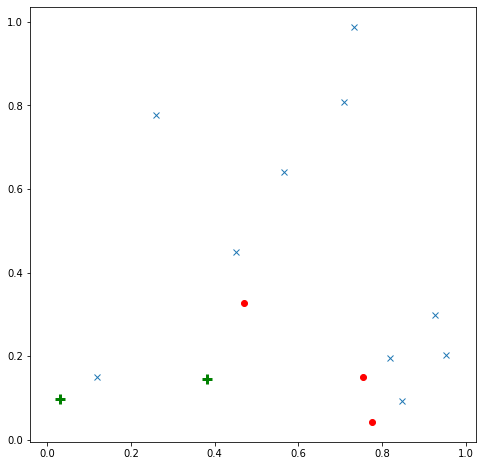

In [42]:
plt.figure(figsize=[8,8])
plt.plot(statics[:Nrefs,0],statics[:Nrefs,1],'+g',markersize=10,mew=3)
plt.plot(statics[Nrefs:,0],statics[Nrefs:,1],'x')
plt.plot(mobilecentres[:,0],mobilecentres[:,1],'ro')
plt.axis('equal')

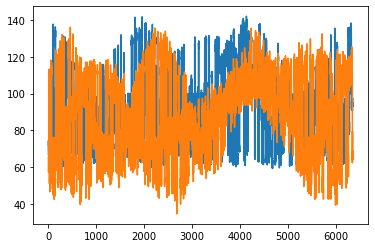

In [43]:
plt.plot(Y[:,0])
plt.plot(Y[:,1])

In [44]:
import numpy as np
from calibration import placeinducingpoints, CalibrationSystem, EQ, SparseModel, Kernel
import gpflow
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

In [45]:
Z = np.linspace(0,Ttotal,15)[:,None]

In [46]:
def transform_fn(samps,Y):
    return Y*tf.exp(samps[:,:,0:1])
k = gpflow.kernels.RBF(1.0,200)+gpflow.kernels.Bias(1.0)
cs = CalibrationSystem(X, Y, Z, refsensor, 1, transform_fn, k,likelihoodstd=7,lr=0.005)
print(cs.Z.shape)
import time
before = time.time()
print("Starting Run")
elbo_record = cs.run(8000)
print(time.time()-before)

(225, 3)
Starting Run
67.05131268501282


In [47]:
cs.X.shape

(12700, 3)

(111385.201640625, 3375309.140625)

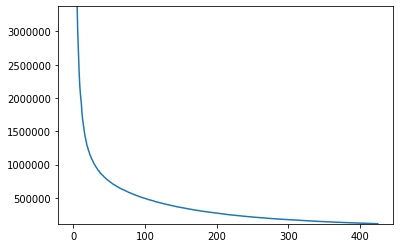

In [31]:
plt.plot(elbo_record)
plt.ylim([np.min(elbo_record)*0.99,np.min(elbo_record)*30])

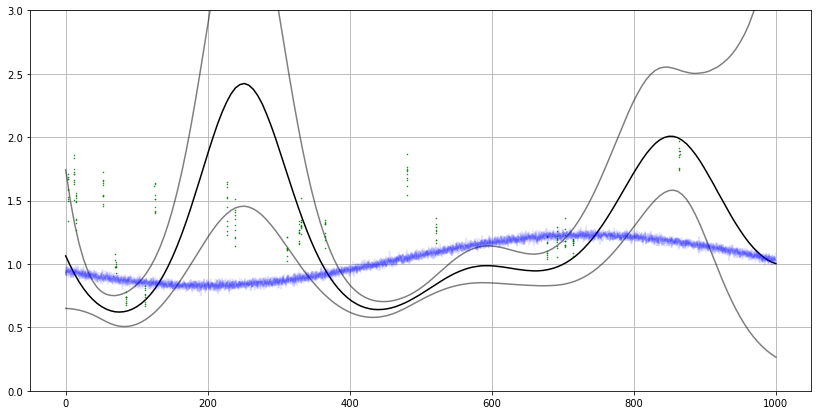

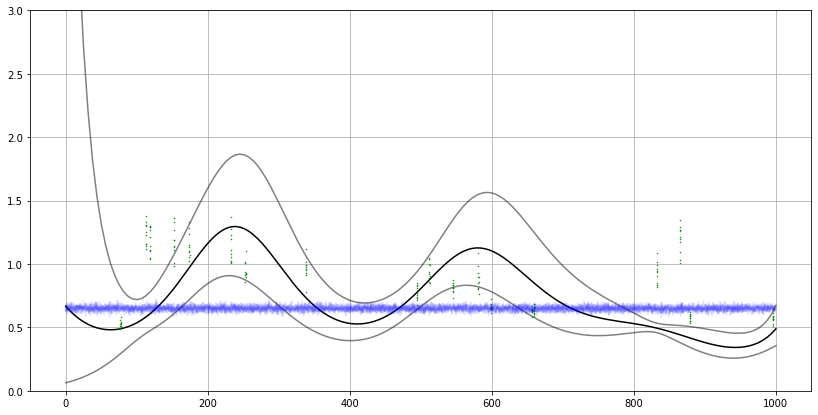

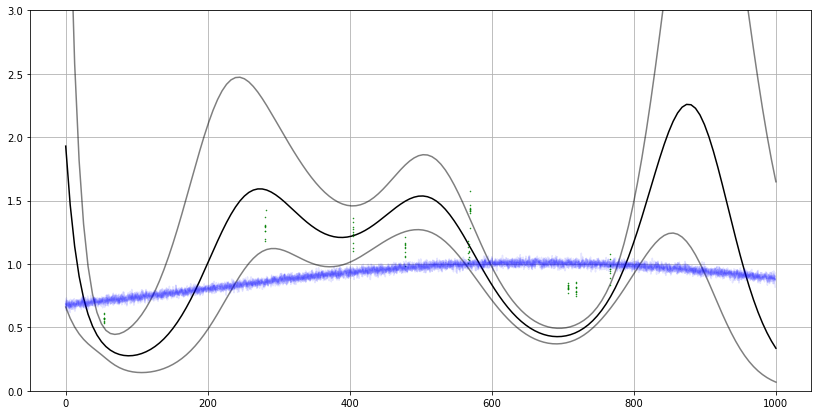

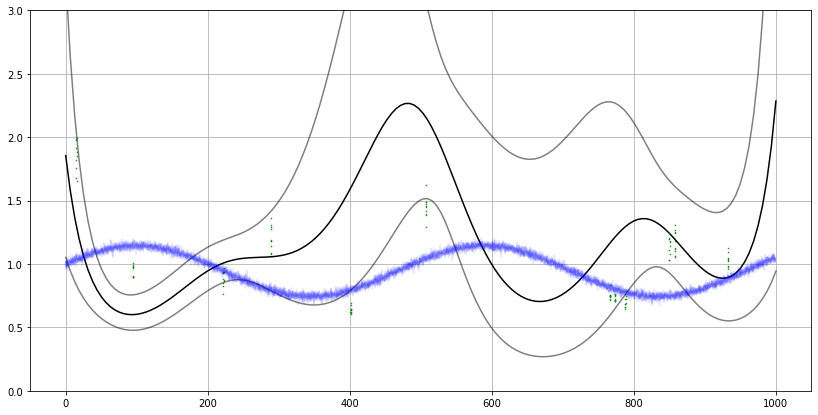

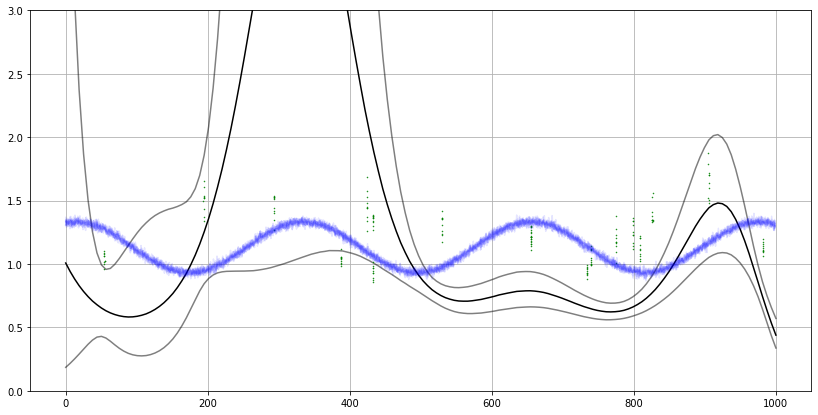

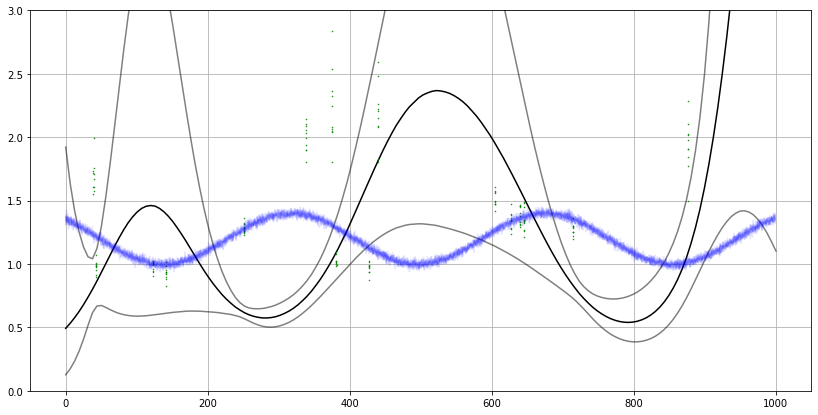

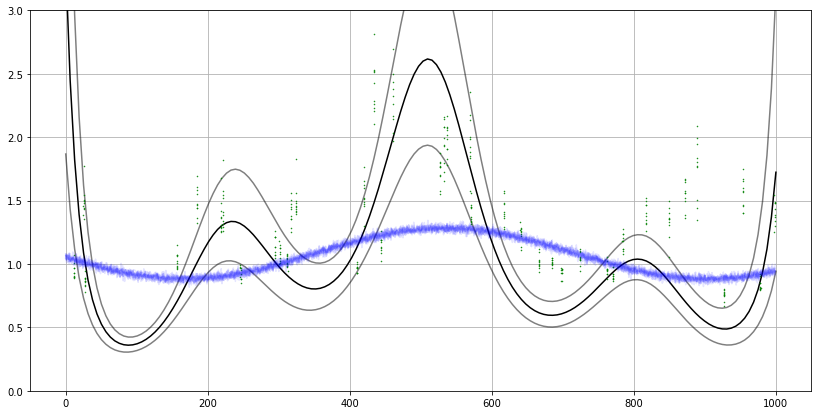

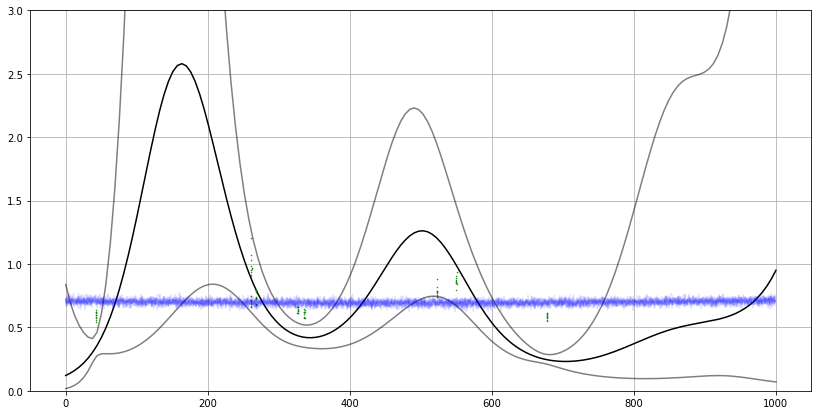

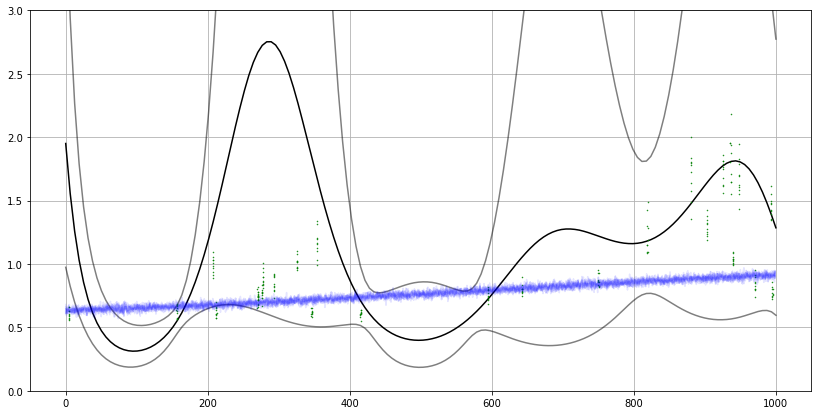

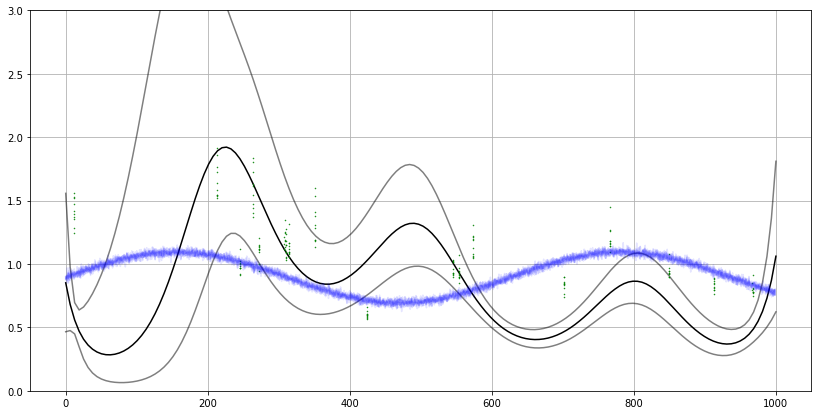

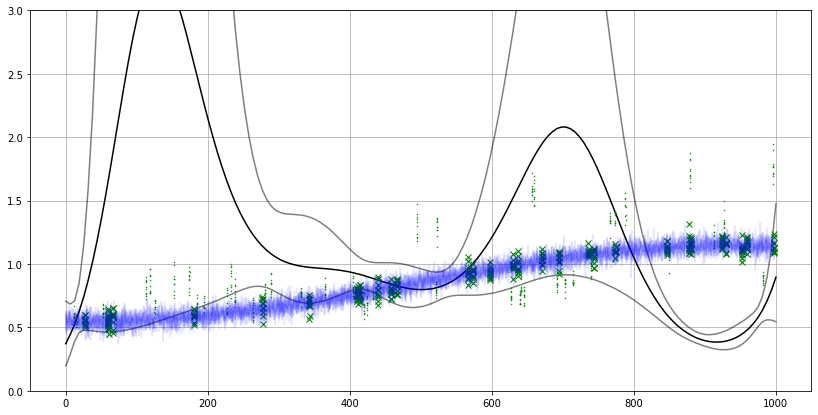

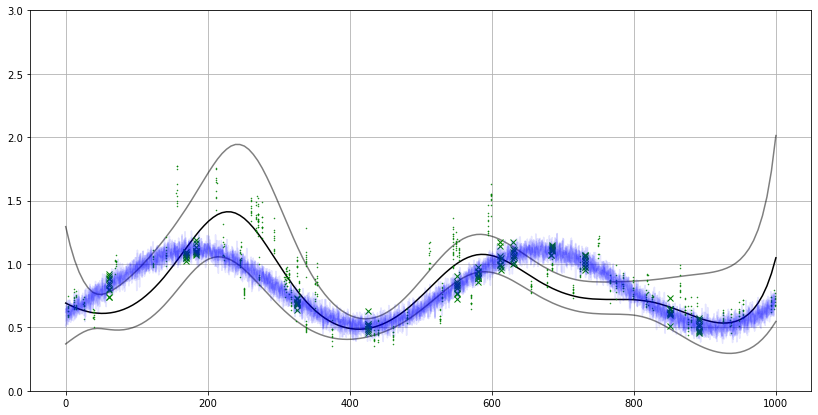

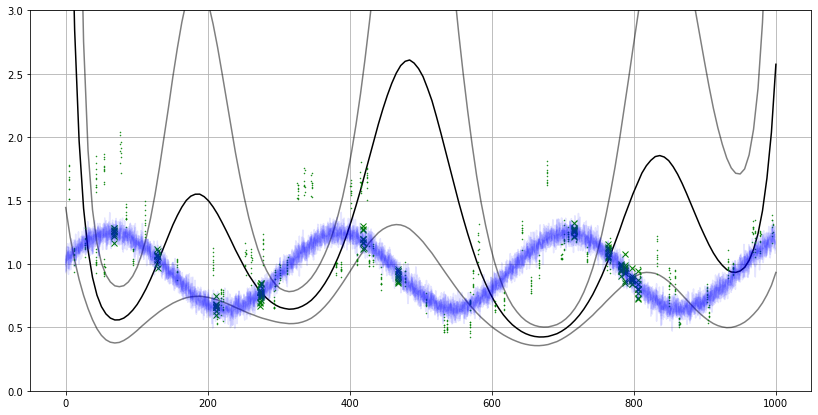

In [32]:
C = 1
for si,refs in enumerate(refsensor):
    if refs: continue
    x = np.linspace(0,Ttotal,160)
    testX = np.zeros([0,3])
    for ci in range(C):
        tempX = np.c_[x,np.ones_like(x)*si,np.full_like(x,ci)]
        testX = np.r_[testX,tempX]#.astype(int)
    testsm = SparseModel(testX,cs.Z,C,Kernel(k))
    qf_mu,qf_cov = testsm.get_qf(cs.mu,cs.scale)
    if cs.mulike is not None:
        qf_mulike,qf_covlike = testsm.get_qf(cs.mulike,cs.scalelike)
        sampslike = testsm.get_samples_one_sensor(cs.mulike,cs.scalelike)
    samps = testsm.get_samples_one_sensor(cs.mu,cs.scale)
    
    plt.figure(figsize=[14,7])
    #plt.plot(x,1/(1+qf_mu[:,0]),'k-')
    plt.plot(x,1/tf.exp(qf_mu[:,0]),'k-')
    #plt.plot(x,1/(1+qf_mu[:151,0])+2*np.sqrt(np.diag(qf_cov)[:151])+2*np.sqrt(np.exp(qf_mulike[:151,0]))/np.mean(Y[:,0]),'k--',alpha=0.5)
    #plt.plot(x,1/(1+qf_mu[:151,0])-2*np.sqrt(np.diag(qf_cov)[:151])-2*np.sqrt(np.exp(qf_mulike[:151,0]))/np.mean(Y[:,0]),'k--',alpha=0.5)
    #plt.plot(x,1/(1+(qf_mu[:151,0]+2*np.sqrt(np.diag(qf_cov)[:151]))+2*np.sqrt(np.exp(qf_mulike[:151,0]))/np.mean(Y[:,0])),'k--',alpha=0.5)
    #r = (1/(1+(qf_mu[:,0]-2*np.sqrt(np.diag(qf_cov)[:])))).numpy()
    #r[r<0] = np.nan
    #plt.plot(x,r,'k-',alpha=0.5)
    plt.plot(x,1/tf.exp((qf_mu[:,0]+2*np.sqrt(np.diag(qf_cov)[:]))),'k-',alpha=0.5)
    plt.plot(x,1/tf.exp((qf_mu[:,0]-2*np.sqrt(np.diag(qf_cov)[:]))),'k-',alpha=0.5)

    senseX = (X[:,1]==si) & (X[:,2]<Nrefs)
    plt.plot(X[senseX,0],Y[senseX,0]/Y[senseX,1],'xg')
    senseX = (X[:,2]==si) & (X[:,1]<Nrefs)
    plt.plot(X[senseX,0],Y[senseX,1]/Y[senseX,0],'xg')
    senseX = (X[:,1]==si)
    plt.plot(X[senseX,0],Y[senseX,0]/Y[senseX,1],'.g',markersize=1)
    senseX = (X[:,2]==si)
    plt.plot(X[senseX,0],Y[senseX,1]/Y[senseX,0],'.g',markersize=1)    
    plt.ylim([0,3])
    #plt.yscale('log')
    plt.grid()
    if si<Nstatic:
        for samp in range(10):
            plt.plot([(getstaticsensortranform(t,100.0,si)/100) for t in np.arange(Ttotal)],'b-',alpha=0.1)
    else:
        for samp in range(10):
            plt.plot([(getmobilesensortranform(t,100.0,si-Nstatic)/100) for t in np.arange(Ttotal)],'b-',alpha=0.1)

In [21]:
X.shape

(1650, 3)

In [22]:
Z.shape

(26, 1)

In [23]:
cs.Z.shape

(1144, 3)

In [24]:
cs.X.shape

(3300, 3)

In [60]:
np.c_[X[:300:10,:],Y[:300:10,1]]

array([[ 36.        ,   1.        ,   3.        ,  71.52172884],
       [ 45.        ,   1.        ,   3.        ,  79.70599436],
       [224.        ,   0.        ,   3.        , 108.23209624],
       [247.        ,   0.        ,   3.        ,  98.46101146],
       [379.        ,   1.        ,   3.        ,  52.80462241],
       [414.        ,   1.        ,   2.        ,  69.88388632],
       [486.        ,   0.        ,   3.        ,  65.75303201],
       [528.        ,   1.        ,   3.        ,  83.43190468],
       [700.        ,   0.        ,   2.        , 101.8502886 ],
       [740.        ,   0.        ,   3.        , 102.54735964],
       [776.        ,   1.        ,   3.        ,  77.51494686],
       [839.        ,   0.        ,   2.        , 114.8550182 ],
       [933.        ,   0.        ,   2.        , 117.45450956],
       [939.        ,   0.        ,   3.        ,  53.90437188]])

In [61]:
getmobilesensortranform(7,100,0)
#def getmobilesensortranform(t,pol,sensor):

43.22494833510842

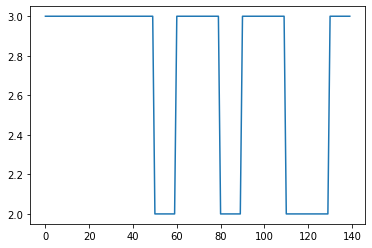

In [62]:
plt.plot(X[:,2])